# Lidar to Camera Projection

Before starting this tutorial, you'll need to have at least one sequence from the Boreas dataset downloaded.
If you're working on a local machine, follow these steps to download a sequence:
1. [Create an AWS account](https://aws.amazon.com/premiumsupport/knowledge-center/create-and-activate-aws-account/)
2. [Install the AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html)
3. Create a `root` folder to store the dataset, example: `/path/to/data/boreas/` Each sequence will then be a folder under `root`.
4. Use the AWS CLI to download a sequence:
```
root=/path/to/data/boreas/
sequence=boreas-2021-09-02-11-42
aws s3 sync s3://boreas/$sequence $root$sequence
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyboreas import BoreasDataset
from pyboreas.utils.utils import get_inverse_tf

bd = BoreasDataset('/path/to/data/boreas/', verbose=True)

SEQ: boreas-2021-09-02-11-42
camera frames: 10293
lidar frames: 9967
radar frames: 4134
-------------------------------
SEQ: boreas-2021-09-07-09-35
camera frames: 8942
lidar frames: 8622
radar frames: 3576
-------------------------------
total camera frames: 19235
total lidar frames: 18589
total radar frames: 7710


## Removing Motion Distortion
`body_rate` is the velocity of the sensor in the sensor frame, $\boldsymbol{\varpi}$

$\Delta t = t - t_{\text{ref}}$ is the time difference between a given measurement time `t` and a reference time, `tref`.

$$
\mathbf{T}_{\text{undistort}} = \exp(\Delta t \boldsymbol{\varpi}^\wedge)
$$

Convenience function: `PointCloud.remove_motion()`

## Transform from Lidar to Camera
$$
\mathbf{x}_{c} = \mathbf{T}_{\text{enu_camera}}^{-1} \mathbf{T}_{\text{enu_lidar}} \mathbf{x}_{l}
$$

Convenience function: `PointCloud.transform()`

## Project onto Image Plane

$$
\begin{bmatrix} u \\ v \end{bmatrix} = \mathbf{D}~\mathbf{P}~\frac{1}{z}~\mathbf{x}_c
$$

$$
\text{where} ~~ \mathbf{D} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{bmatrix}, ~ \mathbf{P} = \begin{bmatrix} f_u & 0 & c_u & 0 \\ 0 & f_v & c_v & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

Convenience function: `PointCloud.project_onto_image()`

body rate in lidar frame:
[[ 5.94788047e+00]
 [ 6.40744648e+00]
 [-3.45478228e-02]
 [-1.03269354e-03]
 [ 4.60532064e-03]
 [-5.62105107e-02]]
T_camera_lidar:
[[ 7.30012029e-01 -6.83434153e-01 -4.41971487e-04 -2.31517386e-02]
 [-1.26750071e-02 -1.28922566e-02 -9.99836554e-01 -2.31676938e-01]
 [ 6.83316750e-01  7.29898314e-01 -1.80740351e-02 -4.71618982e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


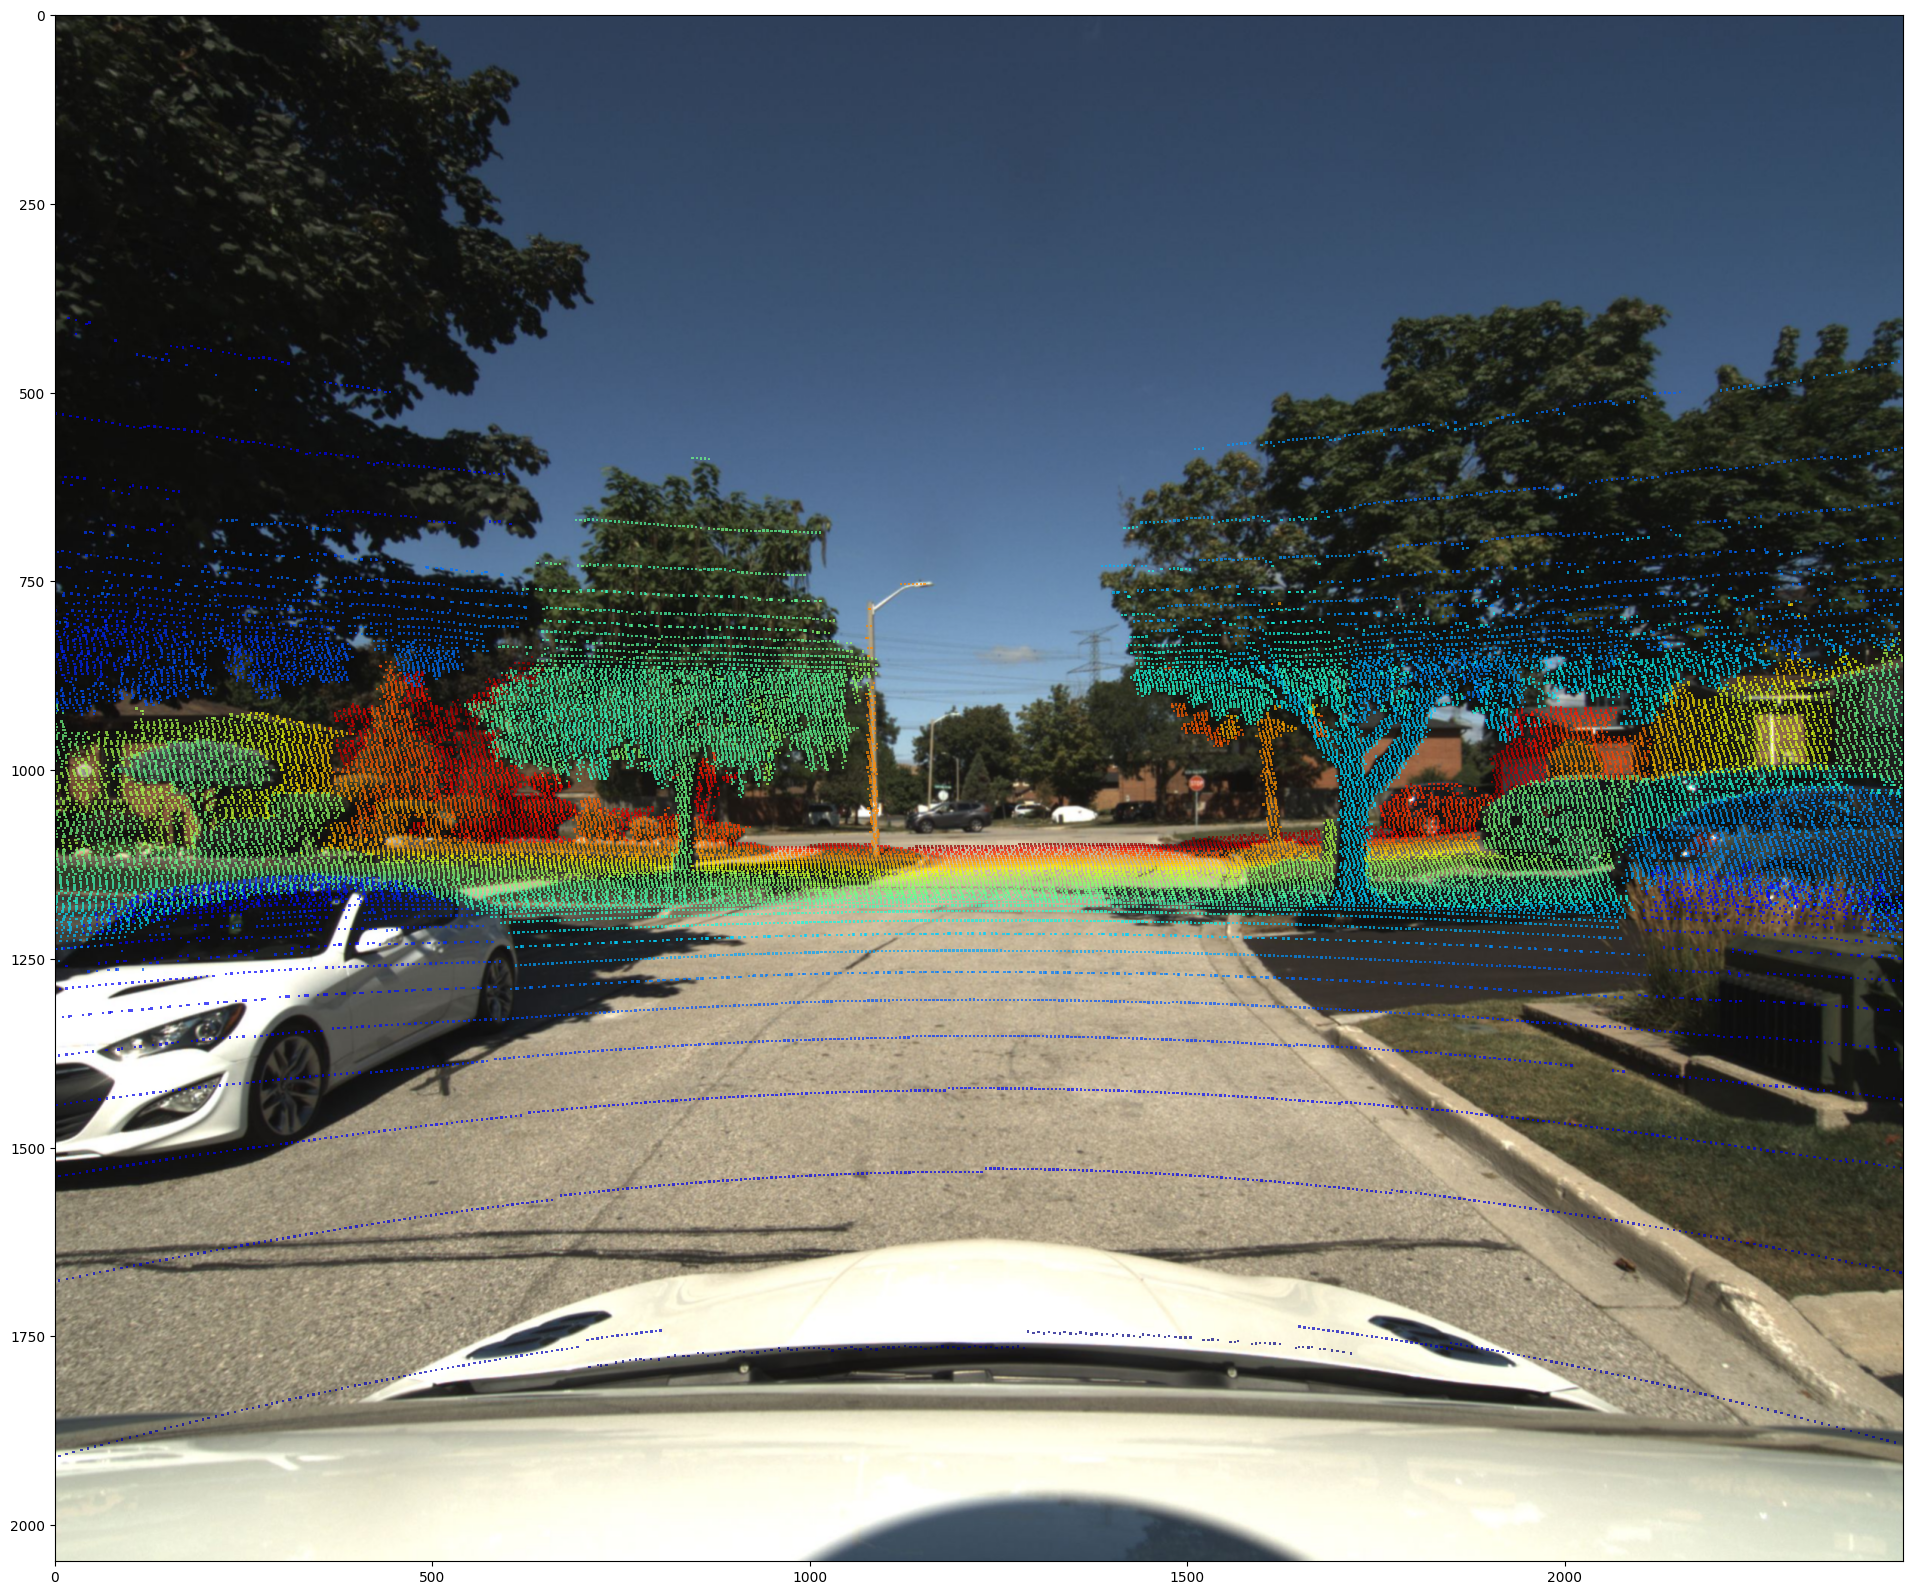

In [4]:
%matplotlib inline
seq = bd.sequences[0]
seq.synchronize_frames(ref='camera')  # simulates having synchronous measurements
idx = 6100  # try different frame indices!
cam = seq.get_camera(idx)
lid = seq.get_lidar(idx)

# Remove motion distortion from pointcloud:
print('body rate in lidar frame:')
print(lid.body_rate)
lid.remove_motion(lid.body_rate)

# Get the transform from lidar to camera:
T_enu_camera = cam.pose
T_enu_lidar = lid.pose
T_camera_lidar = np.matmul(get_inverse_tf(T_enu_camera), T_enu_lidar)
print('T_camera_lidar:')
print(T_camera_lidar)
lid.transform(T_camera_lidar)

# Remove points outside our region of interest
lid.passthrough([-75, 75, -20, 10, 0, 40])  # xmin, xmax, ymin, ymax, zmin, zmax

# Project lidar points onto the camera image, using the projection matrix, P0.
uv, colors = lid.project_onto_image(seq.calib.P0)

# Draw the projection
plt.figure(figsize=(24.48, 20.48), dpi=100)
plt.imshow(cam.img[:, :, ::-1])
plt.xlim(0, 2448)
plt.ylim(2048, 0)
plt.scatter(uv[:, 0], uv[:, 1], c=colors, marker=',', s=3, edgecolors='none', alpha=0.7, cmap='jet')
plt.show()